## Empirical Analysis

In [201]:
# Import necessary modules
import numpy as np
import pandas as pd 
from matplotlib import pyplot
import matplotlib.pyplot as plt  # For plotting graphs 
%matplotlib inline

# standardizes the size of all plots, rather than typing plot(figsize = (12,6)) everytime
from pylab import rcParams
rcParams['figure.figsize'] = 12,6 

from scipy import stats
from datetime import datetime
from functools import reduce
import datetime
import quandl


from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller,grangercausalitytests
from statsmodels.tsa.stattools import ccovf,ccf,periodogram
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import scipy.stats as sp # SciPy for linear regression.

quandl.ApiConfig.api_key = '-kesKc4A8jkkBwyX3rSX'

In [202]:
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# imported the relavant macroecon variables

data = quandl.get(["FRED/ANFCI", # Chicago Fed National Financial Condition Index
                   "FRED/T10YFF", # 10 year Treasury - FFR
                   "FRED/T1YFFM", # 1 year Treasury - FFR
                   
                   "FRED/FEDFUNDS", # Federal Funds Rate
                   "UMICH/SOC1", # UMich: Consumer Sentiment Index
                   "FRED/RECPROUSM156N", # Smoothed U.S. Recession Probabilities
                   "FRED/GDPC1", # Real GDP
                   "FRED/INDPRO", # Industrial Production Index
                   "FRED/WALCL", # Total Assets (Less Eliminations From Consolidation)
                   "FRED/LNS12300060", # Employment to population ratio: 25-54 Yrs
                   "FRED/RPONTSYD", # Overnight Repurchase Agreements: Treasury Securities Purchased by Fed in OMO
                   "FRED/AHETPI", # Average Hourly Earnings for Production & Nonsupervisory Employees
                   "FRED/CPIAUCSL", # CPI
                  "FRED/PSAVERT", # Personal Savings Rate
                  "FRED/CCSA", # UI claims 
                   "FRED/THREEFF4", # Fitted Instantaneous Forward Rate 4 Years Hence
                   "FRED/DGS1"], # 1-Year Treasury Constant Maturity Rate
                   
                  start_date="1978-01-01", end_date="2020-04-01",collapse = 'monthly',date_parser=parser)
#data.tail()

In [204]:
data.columns = ['FRED/ANFCI - Value', 'FRED/T10YFF - Value', 'FRED/T1YFFM - Value', 'FRED/FEDFUNDS - Value', 
                'UMICH/SOC1 - Index', 'FRED/RECPROUSM156N - Value', 'FRED/GDPC1 - Value', 'FRED/INDPRO - Value',
                'FRED/WALCL- Value', 'FRED/LNS12300060 - Value', 'FRED/RPONTSYD - Value', 'FRED/AHETPI - Value',
                'FRED/CPIAUCSL - Value', 'FRED/PSAVERT - Value', 'FRED/CCSA - Value', 'FRED/THREEFF4 - Value',
                'FRED/DGS1 - Value']

# rename the columns
data.rename(columns={'FRED/ANFCI - Value': 'FCI',
                     'FRED/T10YFF - Value': '10yrtre-ffr',
                     'FRED/T1YFFM - Value': '1yrtre-ffr',
                     'FRED/FEDFUNDS - Value': 'fed_fundsR',
                     'UMICH/SOC1 - Index': 'CSI',
                     'FRED/RECPROUSM156N - Value': 'rec_prob',
                     'FRED/GDPC1 - Value': 'real_GDP',
                     'FRED/INDPRO - Value': 'IPI',
                     'FRED/WALCL- Value': "total_assets",
                     'FRED/LNS12300060 - Value': 'pa_emp-pop_ratio',
                     'FRED/RPONTSYD - Value': 'repo_purchFed',
                     'FRED/AHETPI - Value': 'hour_earn', 
                     'FRED/CPIAUCSL - Value': 'CPI',
                     'FRED/PSAVERT - Value': 'PSR',
                     'FRED/CCSA - Value': 'UI_claims',
                     'FRED/THREEFF4 - Value':'4forwardR',
                     'FRED/DGS1 - Value': '1yr_trR'}, inplace=True)
data.head()

,FCI,10yrtre-ffr,1yrtre-ffr,fed_fundsR,CSI,rec_prob,real_GDP,IPI,total_assets,pa_emp-pop_ratio,repo_purchFed,hour_earn,CPI,PSR,UI_claims,4forwardR,1yr_trR
Date,,,,,,,,,,,,,,,,,
1978-01-31,-0.69,1.15,0.58,6.70,83.7,10.45,6329.791,49.2066,NaN,73.0,NaN,5.66,62.7,11.9,2578000.0,NaN,7.26
1978-02-28,-0.63,1.21,0.56,6.78,84.3,0.15,NaN,49.4502,NaN,73.2,NaN,5.69,63.0,11.1,2553000.0,NaN,7.32
1978-03-31,-0.25,1.18,0.52,6.79,78.8,0.00,NaN,50.3928,NaN,73.3,NaN,5.73,63.4,11.0,2473000.0,NaN,7.48
1978-04-30,0.09,0.99,0.56,6.89,81.6,0.00,6574.390,51.4368,NaN,73.5,NaN,5.79,63.9,10.8,2272000.0,NaN,7.70
1978-05-31,0.22,0.99,0.46,7.36,82.9,0.15,NaN,51.6276,NaN,73.4,NaN,5.82,64.5,10.3,2211000.0,NaN,7.94


In [205]:
# since the Real GDP is quarterly, I have used a spline interpolation method to convert into monthly data
inter_realGDP = data['real_GDP'].interpolate(method='spline', order =3)
inter_realGDP.tail(10)

Date
2019-07-31    19121.112000
2019-08-31    19167.056109
2019-09-30    19205.200335
2019-10-31    19221.970000
2019-11-30    19200.670650
2019-12-31    19123.813367
2020-01-31    18974.702000
2020-02-29    18755.093966
2020-03-31    18418.913945
2020-04-30    17978.472195
Name: real_GDP, dtype: float64

In [207]:
merged = pd.merge(data, inter_realGDP, on = 'Date') # merged the interpolated GDP data with the rest of the dataset

merged1 = merged.drop('real_GDP_x', axis =1).rename(columns={'real_GDP_y': 'inter_realGDP'}) 
merged1.drop(merged1.tail(1).index,inplace= True)# drop the last row with missing values as it contains NaN

merged1['real_wage'] = merged1['hour_earn']/merged1['CPI'] # Add a column that calculates the real wage
#merged1.tail()

In [210]:
 # Calculates the percent change of all the variables
change = merged1.pct_change()
#change.head()

In [211]:
# drops rows with NaN values, and replaces inf values with 0
short = change.dropna(inplace = False).replace([np.inf, -np.inf], 0).dropna(axis=1)
short.tail()

,FCI,10yrtre-ffr,1yrtre-ffr,fed_fundsR,CSI,rec_prob,IPI,total_assets,pa_emp-pop_ratio,repo_purchFed,hour_earn,CPI,PSR,UI_claims,4forwardR,1yr_trR,inter_realGDP,real_wage
Date,,,,,,,,,,,,,,,,,,
2019-11-30,-0.029851,1.000000,-1.090909,-0.153005,0.013613,0.153846,0.009280,0.008222,0.000000,0.113362,0.002104,0.002313,0.025974,0.002950,0.064231,0.045752,-0.001108,-0.000208
2019-12-31,-0.030769,0.681818,-1.000000,0.000000,0.025826,12.944444,-0.003663,0.027811,0.001245,-0.752234,0.001260,0.002405,-0.025316,0.044118,0.097072,-0.006250,-0.004003,-0.001142
2020-01-31,0.047619,-1.216216,0.000000,0.000000,0.005035,1.070120,-0.004579,-0.003352,0.002488,0.849311,0.001678,0.001455,0.025974,-0.012394,-0.277008,-0.088050,-0.007797,0.000223
2020-02-29,-0.272727,4.625000,7.500000,0.019355,0.012024,1.206313,0.001129,0.001688,-0.001241,-0.709595,0.003350,0.000889,0.037975,-0.030804,-0.335259,-0.331034,-0.011574,0.002459
2020-03-31,-1.937500,-2.377778,0.764706,-0.588608,-0.117822,0.744592,-0.045129,0.263462,-0.011180,-0.960317,0.005008,-0.004235,0.548780,3.382578,-0.383201,-0.824742,-0.017925,0.009282


In [212]:
short.info() # after dropping the missing values, the dataset truncates to 151 rows

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 151 entries, 2003-01-31 to 2020-03-31
Data columns (total 18 columns):
FCI                 151 non-null float64
10yrtre-ffr         151 non-null float64
1yrtre-ffr          151 non-null float64
fed_fundsR          151 non-null float64
CSI                 151 non-null float64
rec_prob            151 non-null float64
IPI                 151 non-null float64
total_assets        151 non-null float64
pa_emp-pop_ratio    151 non-null float64
repo_purchFed       151 non-null float64
hour_earn           151 non-null float64
CPI                 151 non-null float64
PSR                 151 non-null float64
UI_claims           151 non-null float64
4forwardR           151 non-null float64
1yr_trR             151 non-null float64
inter_realGDP       151 non-null float64
real_wage           151 non-null float64
dtypes: float64(18)
memory usage: 22.4 KB


Graph of measure of inflation (real wage growth) vs measure of employment (prime age employment to population ratio)

While it apprears that they may be weekly positively correlated as they almost move in tandem with each other in several time periods; however, they are weekly negative correlated and stationary.

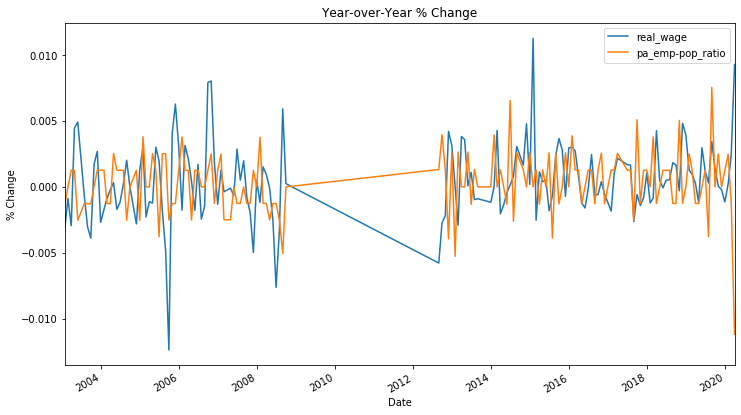

In [193]:
ax = short[['real_wage', 'pa_emp-pop_ratio']].plot(figsize=(12,7),
                                            xlim=['2003-01-31','2020-03-31'], title='Year-over-Year % Change')
ax.autoscale(axis='x',tight=True)
ax.set(ylabel='% Change');

In [194]:
short[['real_wage', 'pa_emp-pop_ratio']].corr() # slightly negatively correlated and stationary variables

,real_wage,pa_emp-pop_ratio
real_wage,1.000000,-0.115391
pa_emp-pop_ratio,-0.115391,1.000000


In [213]:
data1 = short[['10yrtre-ffr', '1yrtre-ffr', 'fed_fundsR', 'CSI', 'rec_prob', 'IPI','pa_emp-pop_ratio', 'PSR',
               'UI_claims', 'inter_realGDP', 'real_wage', 'total_assets', 'repo_purchFed','4forwardR', '1yr_trR' ]]

## Augmented Dickey Fuller Test to check for Stationarity

The series with unit root are: percent changes in the following variables:
UI Claims, 1 year maturity Treasury rate, and real GDP

In [162]:
def adfuller_test(series, signif = 0.05, name = '', verbose = False):
    """Perform ADFuller to test for stationarity of a given series and print report"""
    
    r = adfuller(series, autolag = 'AIC')
    output = {'test_statistic': round(r[0], 4), 'pvalue': round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length = 6): return str(val).ljust(length)
    
    # print sumamry
    print(f'     Augmented Dickey-Fuller Test on "{name}"', "\n    ", '-'*47)
    print(f'  Null Hypothesis: Data has unit too. Non-Stationary.')
    print(f'  Significance Level    = {signif}')
    print(f'  Test Statistic        = {output["test_statistic"]}')
    print(f'  No. of Lags Chosen    = {output["n_lags"]}')
          
    for key, val in r[4].items():
          print(f'  Critical Value {adjust(key)} = {round(val, 3)}')
          
    if p_value <= signif:
          print(f" => P-Value = {p_value}. Rejecting null hypothesis.")
          print(f" => Series is stationary.")
    else:
          print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
          print(f" => Series is non-stationary.")
          
     # ADF Test on each column
for name, column in data1.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

     Augmented Dickey-Fuller Test on "10yrtre-ffr" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -13.9327
  No. of Lags Chosen    = 0
  Critical Value 1%     = -3.475
  Critical Value 5%     = -2.881
  Critical Value 10%    = -2.577
 => P-Value = 0.0. Rejecting null hypothesis.
 => Series is stationary.


     Augmented Dickey-Fuller Test on "1yrtre-ffr" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -11.1205
  No. of Lags Chosen    = 0
  Critical Value 1%     = -3.475
  Critical Value 5%     = -2.881
  Critical Value 10%    = -2.577
 => P-Value = 0.0. Rejecting null hypothesis.
 => Series is stationary.


     Augmented Dickey-Fuller Test on "fed_fundsR" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Sta

## Autocorrelation Plots

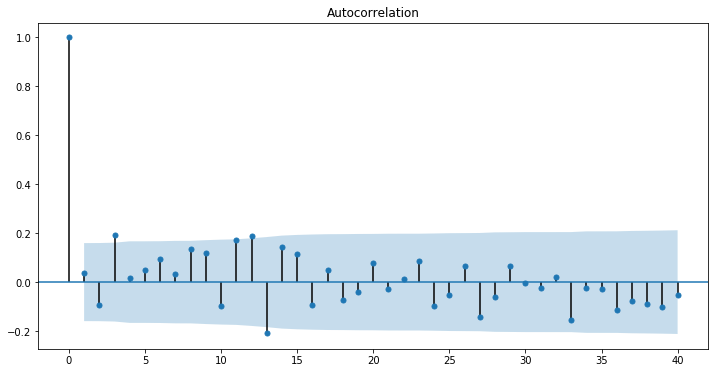

In [187]:
# makes the ACF plot
plot_acf(short['1yr_trR'], lags = 40)
# the plots show strong autocorrelation of lags as spikes gradually reduce, instead of plumeting to 0.
pyplot.show()

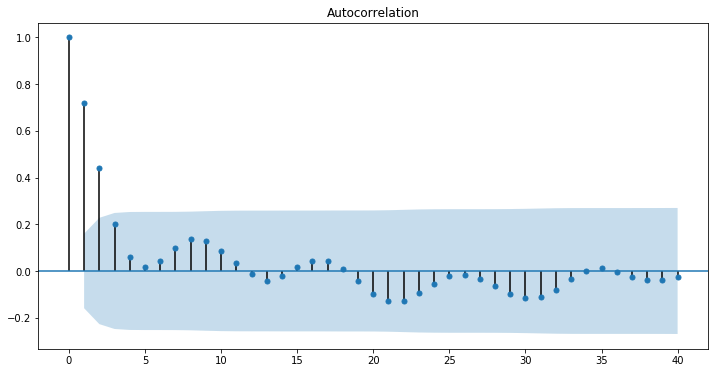

In [190]:
plot_acf(short['inter_realGDP'], lags = 40)
pyplot.show()

## Vector Autoregression Model (VAR)

As a reduced form model, VAR's coefficients are hard to interpret. Instead, we canconstruct the impulse-response functions (IRF) and forecast error variance decomposition (FEVD) to gauge how the variables affect each other.

In [166]:
model = VAR(short[['IPI','pa_emp-pop_ratio', 'PSR', 'real_wage', 'total_assets', 'repo_purchFed']])
results = model.fit(2)
results.summary()

/Users/sudikshajoshi/anaconda3/envs/TSA_COURSE/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 03, Jun, 2020
Time:                     15:33:51
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -32.5023
Nobs:                     149.000    HQIC:                  -33.4359
Log likelihood:           1348.04    FPE:                1.59458e-15
AIC:                     -34.0748    Det(Omega_mle):     9.65328e-16
--------------------------------------------------------------------
Results for equation IPI
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.000482         0.000682           -0.708           0.479
L1.IPI                      0.174548         0.112459            1.552           0.121
L1.pa_emp-pop_ratio         0.582557  

## Impulse Response Functions (IRF)

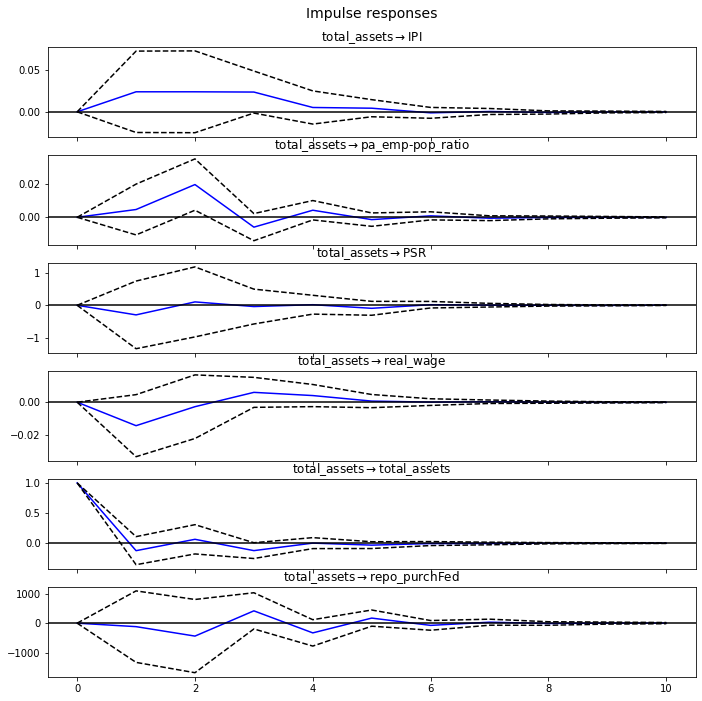

In [175]:
irf = results.irf(10)
irf.plot(impulse='total_assets');

When there is a positive shock of the total assets on the changes in industrial production index (ISI) i.e. when the Fed buys more total assets than normally would, the percent change in ISI boosts by slightly less than 0.025 units and flattens at that level from 1 to 2.5 periods. After that, it gradually descends linearly until the affect of the sock attentuates and dissipates after the 6th period. 

Similary, on applying a positive shock, the percent change in pa_emp_pop ratio rises and reaches the peak in period 2, after which is tumbles down to the negative territory. Thereafter, the ratio approaches the steady state level.

The percent change in wage or wage growth initially react negatively, wherein it reaches the nadir at about -0.018 in period 1.5, and then pushes back up the orginal level of wage growth. There is a modicum of increase - slightly above 0 unit, after which it reduces to its steady state level.

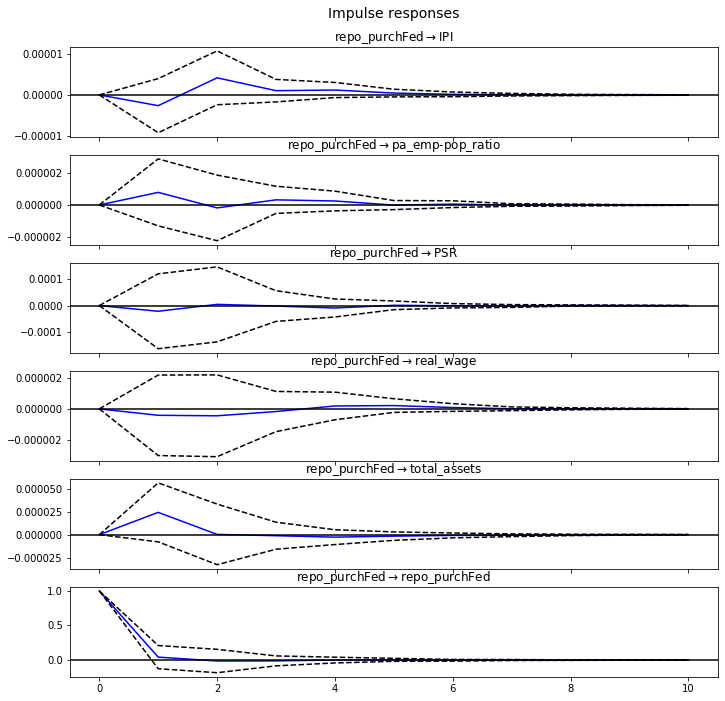

In [174]:
irf.plot(impulse='repo_purchFed');

As the Fed accerleates the monetary shock by buying more overnight repurchase agreements from the open market operations, there are hardly any conspicuous changes in the growth of personal savings rate. It mildly diminishes, and then reverts back to 0 after period 2, converging to the steady state level 5th period onwards. 

## Cumulative IRF

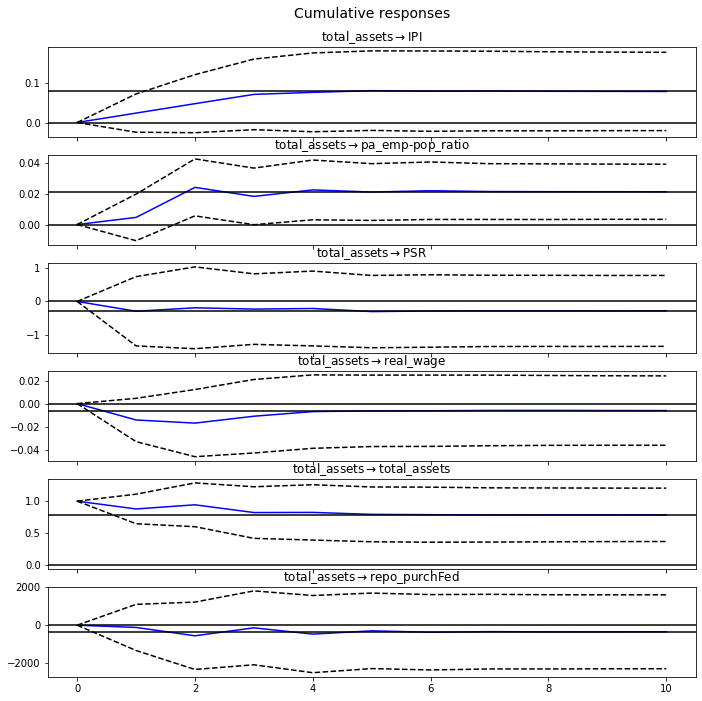

In [178]:
irf.plot_cum_effects(impulse = 'total_assets');

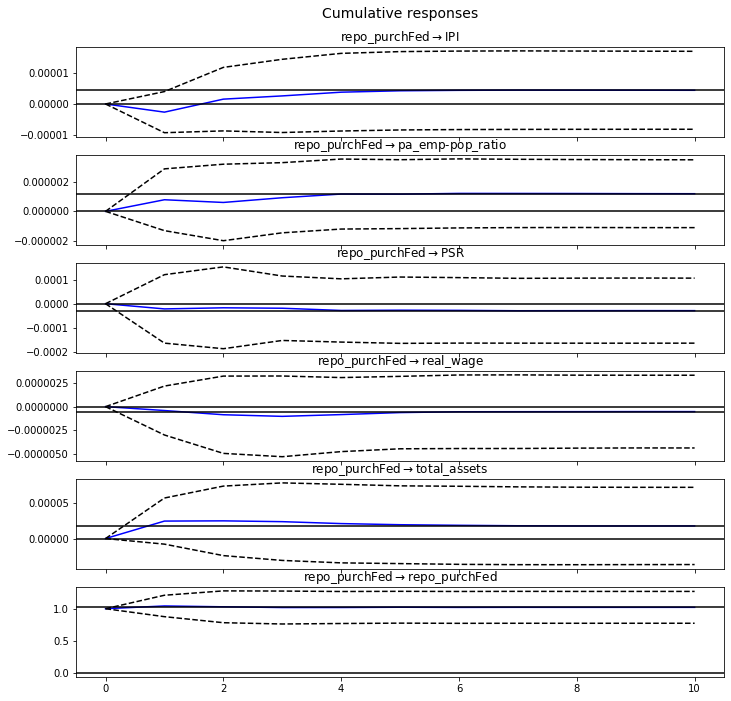

In [179]:
irf.plot_cum_effects(impulse = 'repo_purchFed');

## Forecast Error Variance Decomposition (FEVD)

In [198]:
fevd = results.fevd(5)
fevd.summary()

FEVD for IPI
          IPI  pa_emp-pop_ratio       PSR  real_wage  total_assets  repo_purchFed
0    1.000000          0.000000  0.000000   0.000000      0.000000       0.000000
1    0.952875          0.022839  0.003198   0.011244      0.005819       0.004025
2    0.923672          0.021955  0.013113   0.014778      0.012821       0.013661
3    0.917190          0.021807  0.013038   0.014833      0.018968       0.014163
4    0.915664          0.022269  0.013033   0.014811      0.019288       0.014935

FEVD for pa_emp-pop_ratio
          IPI  pa_emp-pop_ratio       PSR  real_wage  total_assets  repo_purchFed
0    0.090342          0.909658  0.000000   0.000000      0.000000       0.000000
1    0.092982          0.895920  0.000240   0.004339      0.002910       0.003609
2    0.092177          0.849565  0.000326   0.009965      0.044360       0.003607
3    0.091807          0.844763  0.001579   0.010017      0.047685       0.004149
4    0.091269          0.838953  0.001919   0.014007      

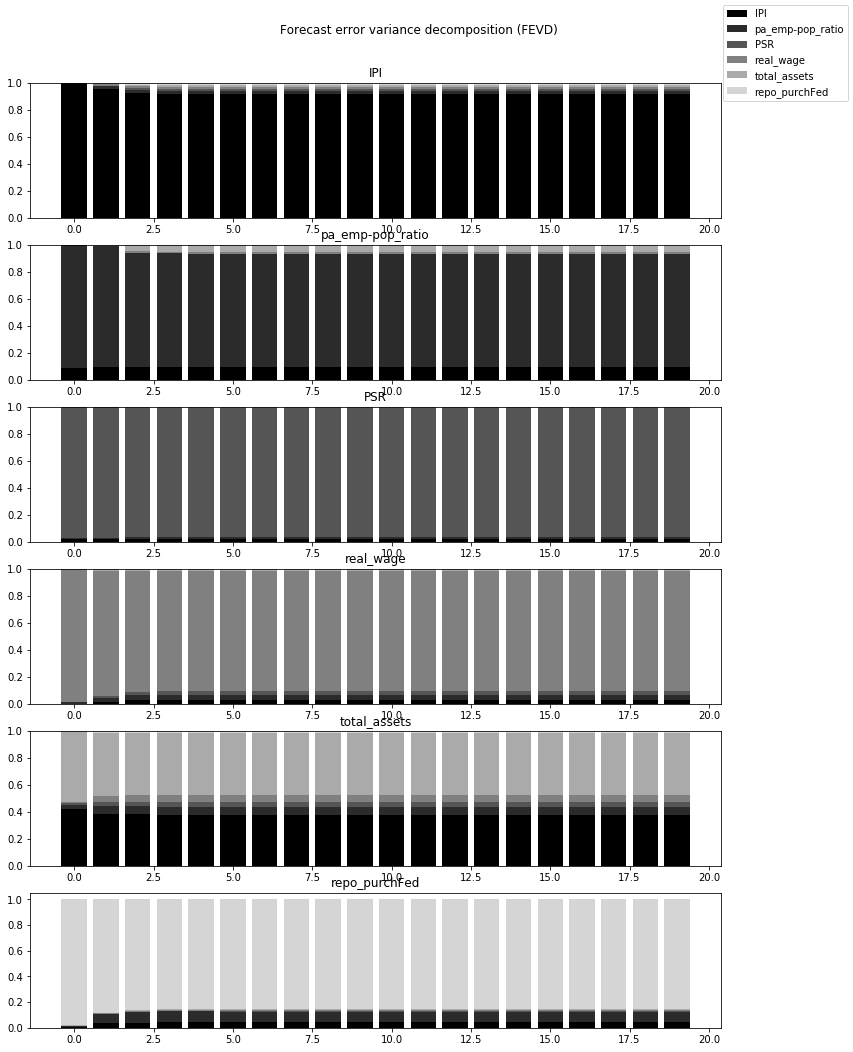

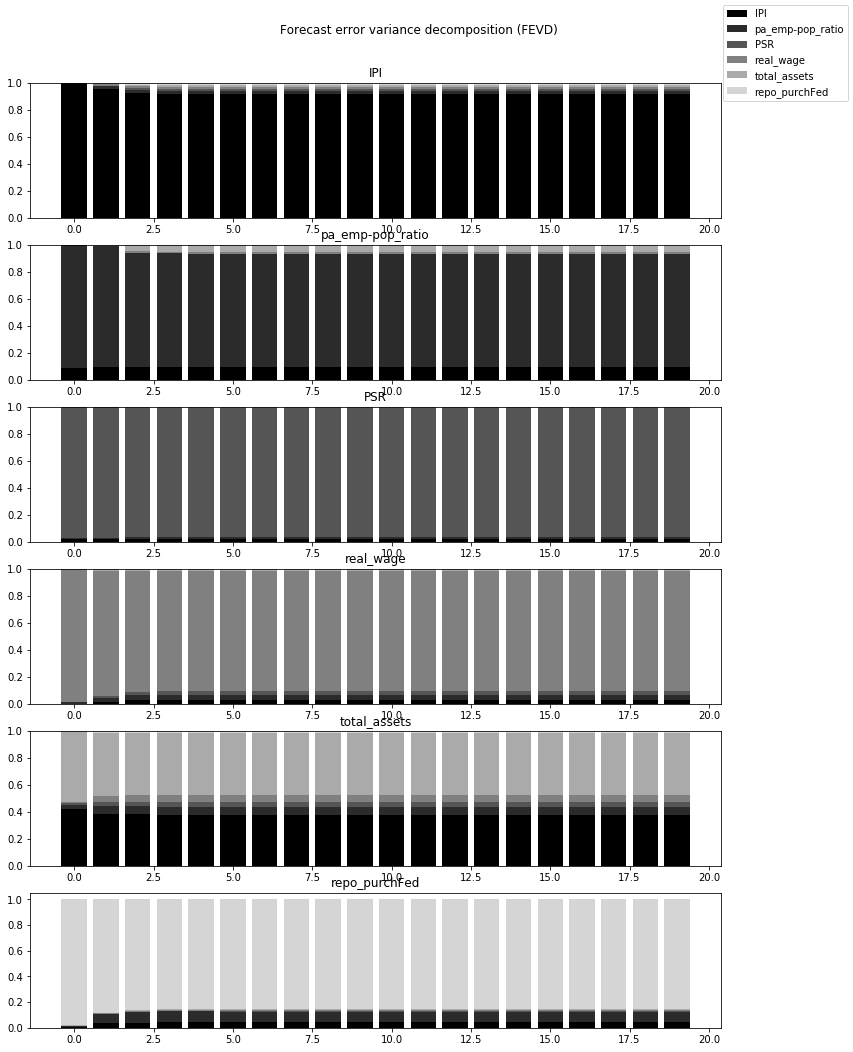

In [197]:
results.fevd(20).plot(figsize = (12,15))

Whilst impulse response functions delineate the impact of a shock to one endogenous variable on to the other variables in the VAR, a VECM distinguishes the variation present in an endogenous variable into the component shocks to the VAR.

Variance decomposition shows how much a shock to one variable (e.g: wage growth, personal savings rate) impacts the variance of the forecast error of a different one (e.g: prime age population to employment ratio, ISI). So, in the short run, i.e. in the same period, we can explain 98.84% of the variance in the forecast error of real wage growth by real wage growth itself. It is strongly exogenous as the percent change in pther variables - PSR, total assets, real wage, etc, only weakly influence in predicting the ISI in the future. 

However, in the long run, the influence of  percent change in ISI in explaining the variance in its forecast error has diminished from 98.84 to 88.71 percent. 